In [28]:
import pandas as pd

df = pd.read_csv('../data/sales.csv')
# df = pd.read_csv('sales.csv')
df.dropna(subset=['price'], inplace=True)

In [29]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

In [30]:
class Cost_Transformer(object):
    
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        self.mean = df.mean()
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        return df.fillna(self.mean)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def cost2num(self, x):
        if type(x) == str: 
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x

In [31]:
features = list(train_raw.columns)
target = 'price'
features.remove(target)

In [32]:
def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

In [33]:
X = train_raw[features]
y = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

# 1. train_test_split

In [34]:
from sklearn.model_selection import train_test_split

**Example:** Split training data in to new training data and validation data.

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y, 
                                                      test_size=0.2, 
                                                      random_state=2019)

**Example:** Find the best **alpha** for Lasso using **validation score**.

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [37]:
alphas = range(1, 30)
# alphas = [0.1, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5, 6]
mse = []
for alpha in alphas:
    steps = [('ctf', Cost_Transformer()),
             ('poly', PolynomialFeatures(degree=30)),
             ('rescale', MinMaxScaler()),
             ('lr', Lasso(alpha=alpha, max_iter=100000))]
    model = Pipeline(steps)
    model = model.fit(X_train, y_train)
    mse.append(mean_squared_error(y_valid, model.predict(X_valid)))

In [38]:
import matplotlib.pylab as plt
%matplotlib inline

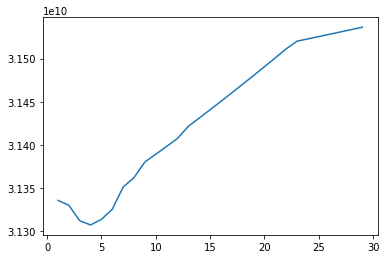

In [39]:
plt.plot(alphas, mse)

<font color='red'>Question:</font> What are training, validation, and testing data for? Why don't we directly use testing score/loss to find the best **alpha**?

### <font color = 'blue'> Is it ok that I changed the range of alpha? </font>

### Training data: The set of data we use to fit the model.
### Validation data: The data set used to evaluate a model fit on the training set while tuning model hyperparameters. 
### Test data: The data set used to evaluate a final model fit on the training dataset.
### If we use the test set to find the best alpha then evaulate the model on the same test set, our result will be too optimistic. We should only use the test set once for the final evaluation.

# 2. K-fold Cross Validation

<font color='red'>Assignment:</font> Use **KFold** instead of **train_test_split** to find the best **alpha**. Please note that X is a DataFrame rather than Numpy Array. Our solution will be a little different from the example in Sklearn tutorial. You will need **iloc** here.

In [54]:
from sklearn.model_selection import KFold

In [41]:
kf = KFold(n_splits = 5)

In [55]:
import numpy as np

alphas = range(1, 30)
# alphas = [0.1, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5, 6]
err_alphas = []
for alpha in alphas:
    steps = [('ctf', Cost_Transformer()),
             ('poly', PolynomialFeatures(degree = 30)),
             ('rescale', MinMaxScaler()),
             ('lr', Lasso(alpha = alpha, max_iter = 100000))]
    mse_kf = []
    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        model_kf = Pipeline(steps)
        model_kf = model_kf.fit(X_train, y_train)
        mse_kf.append(mean_squared_error(y_valid, model_kf.predict(X_valid)))
    err_alphas.append(np.mean(mse_kf))

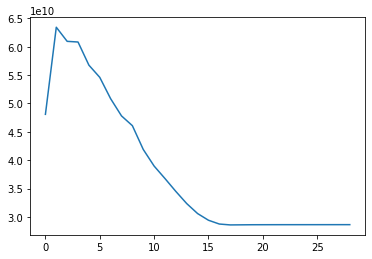

In [56]:
plt.plot(err_alphas)

<font color='red'>Question:</font> What is the difference between **KFold** and **train_test_split**? What is the advantages and disadvanteges of k-fold cross validation?

### train_test_split introduces bias since you are not using all of your data, while KFold uses all the data.
### train_test_split: pros: (1) Fully independent data (2) only needs to run once therefore low computational cost. cons: Introduces bias
### KFold: pros: Less bias. cons: needs to run K times, therefore high computational cost.

# 3. GridSearchCV

<font color='red'>Assignment:</font> By now, we have only tuned the value of **alpha**. Actually, **degree** in **PolynomialFeatures** is also a hyper parameter. Can we find the best values for both of them? You can try to use **GridSearchCV**, and also **make_scorer**.

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [45]:
parameters = {'lasso__alpha': range(1,10), 'poly__degree': range(1,10)}

In [46]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

In [47]:
steps = [('ctf', Cost_Transformer()),
        ('poly', PolynomialFeatures()),
        ('rescale', MinMaxScaler()),
        ('lasso', Lasso(max_iter = 100))]
pipe = Pipeline(steps)

In [48]:
model_gsv = GridSearchCV(pipe, parameters, cv = 5, scoring = scorer)

In [49]:
model_gsv

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ctf',
                                        <__main__.Cost_Transformer object at 0x000001CDCE5DF308>),
                                       ('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('rescale',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=100,
                                

In [50]:
model_gsv = model_gsv.fit(X, y)

C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30242588898389.965, tolerance: 9825112377.678791
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31046436754529.08, tolerance: 9445576142.780487
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31929943194118.58, tolerance: 9649162975.731033
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29457800719056.035, tolerance: 9825112377.678791
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29853014050835.953, tolerance: 9445576142.780487
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31061183241700.945, tolerance: 9649162975.731033
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28685379461232.688, tolerance: 9825112377.678791
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28679184429582.164, tolerance: 9445576142.780487
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30203349270806.316, tolerance: 9649162975.731033
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27924499253795.42, tolerance: 9825112377.678791
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27521524485110.004, tolerance: 9445576142.780487
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29354643192066.855, tolerance: 9649162975.731033
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22941517238064.836, tolerance: 9445576142.780487
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26848486625539.387, tolerance: 9649162975.731033
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23599624500689.094, tolerance: 8999377254.65427
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24968339469917.227, tolerance: 9825112377.678791
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20825555584697.42, tolerance: 9445576142.780487
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25288846265315.79, tolerance: 9649162975.731033
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23731715318858.52, tolerance: 9825112377.678791
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18788597179912.523, tolerance: 9445576142.780487
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23618417520055.945, tolerance: 9649162975.731033
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16834891942142.312, tolerance: 9445576142.780487
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22013867696074.793, tolerance: 9649162975.731033
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19897878187583.992, tolerance: 8999377254.65427
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20391603819048.36, tolerance: 9649162975.731033
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18458939054196.203, tolerance: 8999377254.65427
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21157570192223.625, tolerance: 9063490963.889975
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13177866591506.156, tolerance: 9445576142.780487
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18729995575333.35, tolerance: 9649162975.731033
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16993155173111.086, tolerance: 8999377254.65427
  positive)
C:\Users\chen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

In [51]:
model_gsv.best_params_

{'lasso__alpha': 1, 'poly__degree': 3}

### <font color = 'blue'> Need discussion about this notebook. </font>

In [52]:
model_gsv

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ctf',
                                        <__main__.Cost_Transformer object at 0x000001CDCE5DF308>),
                                       ('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('rescale',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=100,
                                

In [53]:
model_gsv.cv_results_


{'mean_fit_time': array([0.01079392, 0.01199241, 0.01339564, 0.01384735, 0.01419773,
        0.01418734, 0.01658959, 0.01819015, 0.01698995, 0.01379156,
        0.01439137, 0.01259131, 0.01299319, 0.01318979, 0.01399174,
        0.01658964, 0.01963034, 0.01918845, 0.01419101, 0.0163898 ,
        0.01419106, 0.01279168, 0.01339116, 0.01359076, 0.0193872 ,
        0.01758862, 0.01779242, 0.01499143, 0.014991  , 0.01319361,
        0.01199279, 0.01399245, 0.01259217, 0.01658959, 0.01638989,
        0.01738915, 0.01439004, 0.01479106, 0.0141911 , 0.01239347,
        0.01349282, 0.01459179, 0.01579113, 0.01678944, 0.01819034,
        0.01429272, 0.01459098, 0.01259212, 0.01369233, 0.01359215,
        0.01339073, 0.01698999, 0.01718917, 0.01678982, 0.01419101,
        0.01499057, 0.01299243, 0.0153903 , 0.01299205, 0.01299171,
        0.01579089, 0.01639009, 0.01849155, 0.01119313, 0.01479063,
        0.012992  , 0.01262331, 0.01282635, 0.01379128, 0.01738787,
        0.01669083, 0.01720099,